In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

In [ ]:
def Data_load(directory, size=224, sigmaX=10):
  IMGS = []
  for img_name in tqdm(os.listdir(directory)):
    _,ext = os.path.splitext(img_name)
    path = os.path.join(directory, img_name)
    if ext == ".png":
      img = np.asarray(Image.open(path).convert("RGB"))
      img = cv2.resize(img, (size,size))
      IMGS.append(np.array(img))
  return IMGS
      

benign_train = np.array(Data_load("/content/drive/MyDrive/Breast_Cancer_Project/BreaKHis 400X/train/benign"))
malignant_train = np.array(Data_load("/content/drive/MyDrive/Breast_Cancer_Project/BreaKHis 400X/train/malignant"))
benign_test = np.array(Data_load("/content/drive/MyDrive/Breast_Cancer_Project/BreaKHis 400X/test/benign"))
malignant_test = np.array(Data_load("/content/drive/MyDrive/Breast_Cancer_Project/BreaKHis 400X/test/malignant"))

100%|██████████| 369/369 [00:12<00:00, 30.08it/s]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def Plot_data(data):
  fig, axs = plt.subplots(nrows=5, ncols=4)

  # Iterate over each subplot and plot the data
  k=0
  for i in range(5):
      for j in range(4):
          axs[i,j].imshow(data[k], cmap='gray')
          axs[i,j].axis('off')
          k+=1

  # Show the plot
  plt.show()



def accuracy_plot(history):
  sns.set()
  acc = history.history['accuracy']
  validation_acc = history.history['val_accuracy']
  loss = history.history['loss']
  validation_loss = history.history['val_loss']
  step_per_epoch = range(1, len(loss) + 1)
  
  plt.plot(step_per_epoch, acc, color='g', label='Training Accuracy')
  plt.plot(step_per_epoch, validation_acc, color='r', label='Validation Accuracy')
  plt.plot(step_per_epoch, loss, color='b', label='Training Loss')
  plt.plot(step_per_epoch, validation_loss, color='y', label='Validation Loss')
  plt.title('Training, Validation Accuracy, Testing, Validation Loss')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()

  plt.figure()
  plt.show()

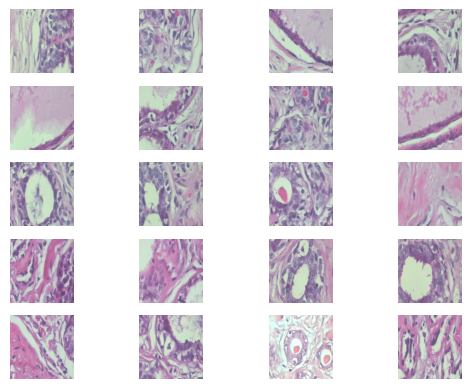

In [ ]:
Plot_data(benign_train)

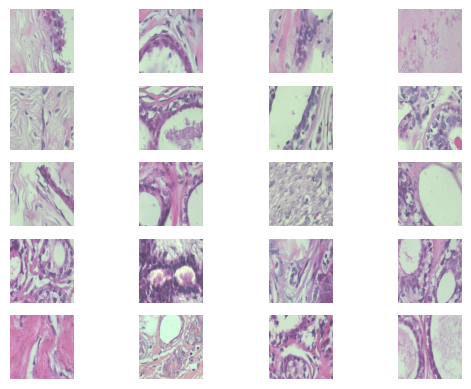

In [ ]:
Plot_data(benign_test)

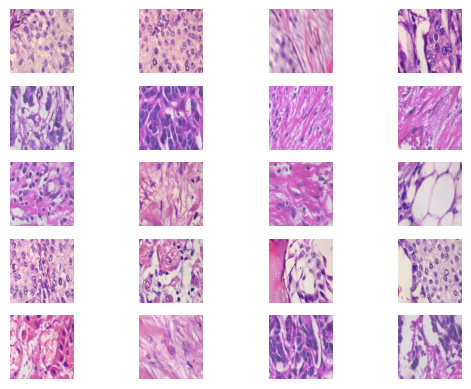

In [ ]:
Plot_data(malignant_test)

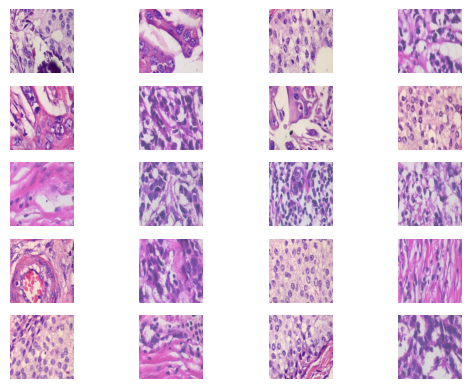

In [ ]:
Plot_data(malignant_train)

In [ ]:
Y_train = np.concatenate((np.zeros(len(benign_train)),np.ones(len(malignant_train))),axis=0)
Y_test = np.concatenate((np.zeros(len(benign_test)),np.ones(len(malignant_test))),axis=0)

In [ ]:
X_train = np.concatenate((benign_train, malignant_train), axis=0)
X_test = np.concatenate((benign_test, malignant_test), axis=0)

In [ ]:
from keras.utils.np_utils import to_categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [ ]:
from keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.models import Sequential
from keras.optimizers import Adam
from keras import backend as K
import gc



def build_model(backbone=None, lr=1e-4):
    model = Sequential()
    if backbone != None:
      model.add(backbone)
    else:
      model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

K.clear_session()
gc.collect()



117804

In [ ]:
train_gen =ImageDataGenerator(zoom_range=2,
                              rotation_range=90)

In [ ]:
model = build_model(lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 220, 220, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 218, 218, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 218, 218, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 216, 216, 64)      1

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:

history1 = model.fit(
    train_gen.flow(X_train, Y_train, batch_size=32),
    steps_per_epoch=X_train.shape[0] / 32,
    epochs=10,
    validation_data=(X_test, Y_test),
)

Epoch 1/10
35/35 [==============================] - 35s 639ms/step - loss: 0.7375 - accuracy: 0.7822 - val_loss: 10.9449 - val_accuracy: 0.3229
Epoch 2/10
35/35 [==============================] - 18s 501ms/step - loss: 0.6101 - accuracy: 0.7805 - val_loss: 1.1976 - val_accuracy: 0.7908
Epoch 3/10
35/35 [==============================] - 17s 475ms/step - loss: 0.6278 - accuracy: 0.7779 - val_loss: 1.7566 - val_accuracy: 0.6844
Epoch 4/10
35/35 [==============================] - 17s 482ms/step - loss: 0.5828 - accuracy: 0.7814 - val_loss: 0.9950 - val_accuracy: 0.8275
Epoch 5/10
35/35 [==============================] - 19s 509ms/step - loss: 0.6352 - accuracy: 0.7901 - val_loss: 0.7435 - val_accuracy: 0.8257
Epoch 6/10
35/35 [==============================] - 18s 493ms/step - loss: 0.6255 - accuracy: 0.7962 - val_loss: 1.5577 - val_accuracy: 0.6330
Epoch 7/10
35/35 [==============================] - 18s 497ms/step - loss: 0.6620 - accuracy: 0.7962 - val_loss: 0.9280 - val_accuracy: 0.779

In [ ]:
model.evaluate(X_test, Y_test)

18/18 [==============================] - 1s 51ms/step - loss: 3.3339 - accuracy: 0.3523


[3.3339147567749023, 0.35229358077049255]

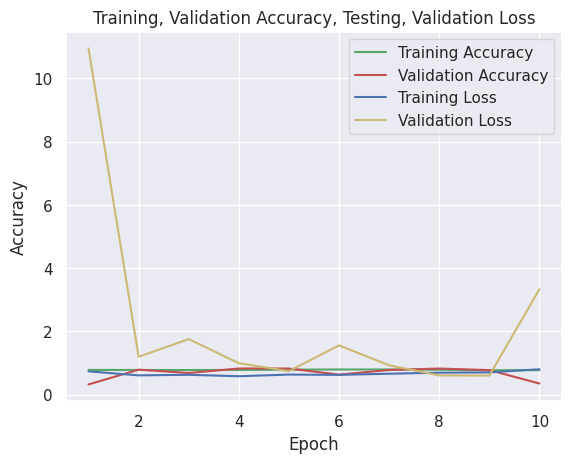

<Figure size 640x480 with 0 Axes>

In [ ]:
accuracy_plot(history1)

1/1 [==============================] - 0s 124ms/step
[0]
benign


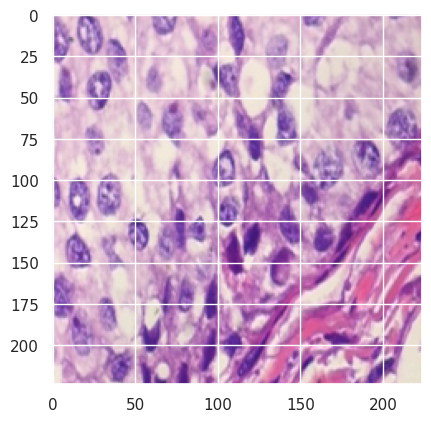

In [ ]:
from keras.preprocessing import image
label = {0:"benign", 1:"malignant"}
img_ = Image.open("/content/drive/MyDrive/Breast_Cancer_Project/BreaKHis 400X/train/malignant/SOB_M_DC-14-11031-400-001.png").resize((224, 224))
imag = np.array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

In [ ]:
import keras
from keras.models import Model

restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
restnet.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
model = build_model(restnet, lr = 1e-4)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 5, 16)          294928    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 32)          4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 1, 1, 64)         

In [ ]:
history2 = model.fit(
    train_gen.flow(X_train, Y_train, batch_size=32),
    steps_per_epoch=X_train.shape[0] / 32,
    epochs=10,
    validation_data=(X_test, Y_test),
)

Epoch 1/10
35/35 [==============================] - 37s 731ms/step - loss: 0.8296 - accuracy: 0.5479 - val_loss: 0.6911 - val_accuracy: 0.5761
Epoch 2/10
35/35 [==============================] - 20s 551ms/step - loss: 0.7453 - accuracy: 0.6115 - val_loss: 0.5979 - val_accuracy: 0.6972
Epoch 3/10
35/35 [==============================] - 22s 600ms/step - loss: 0.6051 - accuracy: 0.7439 - val_loss: 0.5274 - val_accuracy: 0.7835
Epoch 4/10
35/35 [==============================] - 20s 557ms/step - loss: 0.5144 - accuracy: 0.8057 - val_loss: 0.5265 - val_accuracy: 0.7725
Epoch 5/10
35/35 [==============================] - 20s 552ms/step - loss: 0.4805 - accuracy: 0.8275 - val_loss: 0.3913 - val_accuracy: 0.8257
Epoch 6/10
35/35 [==============================] - 21s 583ms/step - loss: 0.4398 - accuracy: 0.8467 - val_loss: 0.7796 - val_accuracy: 0.6936
Epoch 7/10
35/35 [==============================] - 21s 573ms/step - loss: 0.4222 - accuracy: 0.8528 - val_loss: 0.6231 - val_accuracy: 0.7028

In [ ]:
model.evaluate(X_test, Y_test)

18/18 [==============================] - 2s 92ms/step - loss: 0.4966 - accuracy: 0.7798


[0.4966054856777191, 0.7798165082931519]

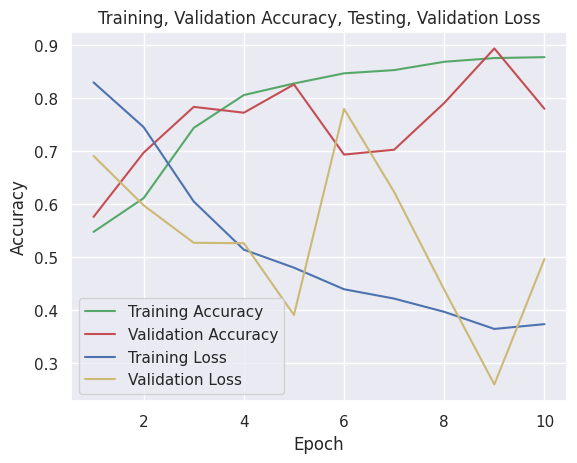

<Figure size 640x480 with 0 Axes>

In [ ]:
accuracy_plot(history2)

1/1 [==============================] - 1s 1s/step
[1]
malignant


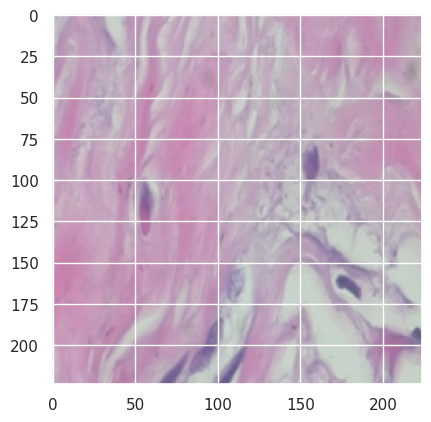

In [ ]:
from keras.preprocessing import image
label = {0:"benign", 1:"malignant"}
img_ = Image.open("/content/drive/MyDrive/Breast_Cancer_Project/BreaKHis 400X/train/benign/SOB_B_A-14-22549AB-400-002.png").resize((224, 224))
imag = np.array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

In [ ]:
densenet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(densenet, lr = 1e-4)
model.summary()

74836368/74836368 [==============================] - 4s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 5, 16)          276496    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 32)          4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                       

In [ ]:
history3 = model.fit(
    train_gen.flow(X_train, Y_train, batch_size=32),
    steps_per_epoch=X_train.shape[0] / 32,
    epochs=10,
    validation_data=(X_test, Y_test),
)

Epoch 1/10
35/35 [==============================] - 73s 1s/step - loss: 0.7591 - accuracy: 0.5523 - val_loss: 0.6550 - val_accuracy: 0.6734
Epoch 2/10
35/35 [==============================] - 25s 693ms/step - loss: 0.6419 - accuracy: 0.6829 - val_loss: 0.5959 - val_accuracy: 0.6899
Epoch 3/10
35/35 [==============================] - 24s 664ms/step - loss: 0.5173 - accuracy: 0.8040 - val_loss: 0.6024 - val_accuracy: 0.6862
Epoch 4/10
35/35 [==============================] - 25s 691ms/step - loss: 0.4642 - accuracy: 0.8267 - val_loss: 0.5871 - val_accuracy: 0.7009
Epoch 5/10
35/35 [==============================] - 26s 709ms/step - loss: 0.4216 - accuracy: 0.8632 - val_loss: 0.4045 - val_accuracy: 0.8000
Epoch 6/10
35/35 [==============================] - 25s 704ms/step - loss: 0.3894 - accuracy: 0.8763 - val_loss: 0.2805 - val_accuracy: 0.8862
Epoch 7/10
35/35 [==============================] - 24s 667ms/step - loss: 0.3723 - accuracy: 0.8841 - val_loss: 0.2400 - val_accuracy: 0.9174
Ep

In [ ]:
model.evaluate(X_test, Y_test)

18/18 [==============================] - 3s 139ms/step - loss: 0.2011 - accuracy: 0.9394


[0.2010803371667862, 0.9394495487213135]

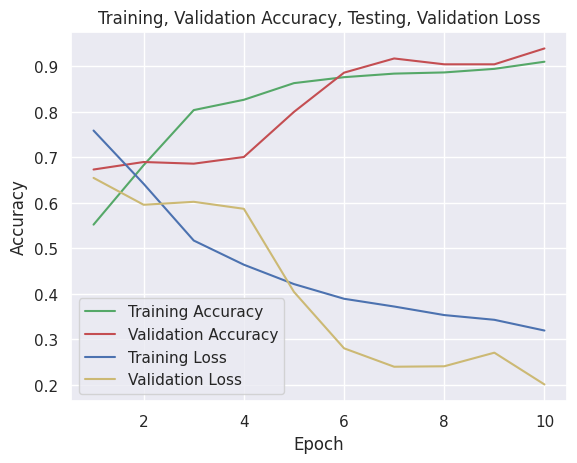

<Figure size 640x480 with 0 Axes>

In [ ]:
accuracy_plot(history3)

1/1 [==============================] - 4s 4s/step
[0]
benign


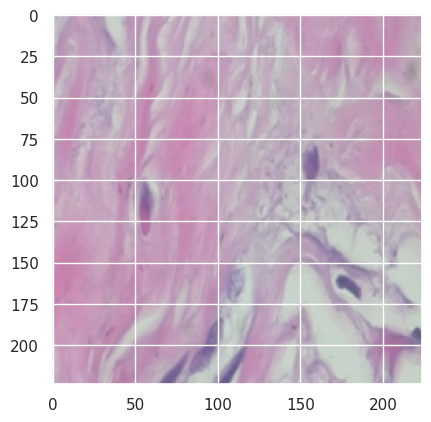

In [ ]:
from keras.preprocessing import image
label = {0:"benign", 1:"malignant"}
img_ = Image.open("/content/drive/MyDrive/Breast_Cancer_Project/BreaKHis 400X/train/benign/SOB_B_A-14-22549AB-400-002.png").resize((224, 224))
imag = np.array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

In [ ]:
mobilenet = MobileNet(input_shape=(224,224,3),
            include_top=False,
            weights='imagenet')

model = build_model(mobilenet, lr = 1e-4)
model.summary()

17225924/17225924 [==============================] - 2s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 5, 5, 16)          147472    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 3, 3, 32)          4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 3, 3, 32)         0         
 g2D)                                                  

In [ ]:
history4 = model.fit(
    train_gen.flow(X_train, Y_train, batch_size=32),
    steps_per_epoch=X_train.shape[0] / 32,
    epochs=10,
    validation_data=(X_test, Y_test),
)

Epoch 1/10
35/35 [==============================] - 22s 508ms/step - loss: 0.8203 - accuracy: 0.5331 - val_loss: 0.7133 - val_accuracy: 0.4514
Epoch 2/10
35/35 [==============================] - 16s 438ms/step - loss: 0.7961 - accuracy: 0.5418 - val_loss: 0.6429 - val_accuracy: 0.6771
Epoch 3/10
35/35 [==============================] - 16s 436ms/step - loss: 0.6887 - accuracy: 0.6455 - val_loss: 0.5417 - val_accuracy: 0.7670
Epoch 4/10
35/35 [==============================] - 16s 435ms/step - loss: 0.6397 - accuracy: 0.6725 - val_loss: 0.4618 - val_accuracy: 0.8128
Epoch 5/10
35/35 [==============================] - 16s 430ms/step - loss: 0.5768 - accuracy: 0.7535 - val_loss: 0.4608 - val_accuracy: 0.7743
Epoch 6/10
35/35 [==============================] - 16s 437ms/step - loss: 0.5308 - accuracy: 0.7770 - val_loss: 0.3634 - val_accuracy: 0.8440
Epoch 7/10
35/35 [==============================] - 16s 436ms/step - loss: 0.4864 - accuracy: 0.8049 - val_loss: 0.4013 - val_accuracy: 0.8147

In [ ]:
model.evaluate(X_test, Y_test)

18/18 [==============================] - 1s 34ms/step - loss: 0.3003 - accuracy: 0.8862


[0.3002913296222687, 0.8862385153770447]

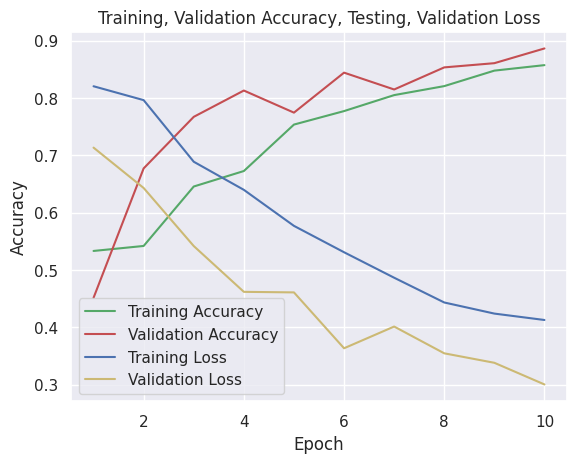

<Figure size 640x480 with 0 Axes>

In [ ]:
accuracy_plot(history4)

1/1 [==============================] - 1s 1s/step
[1]
malignant


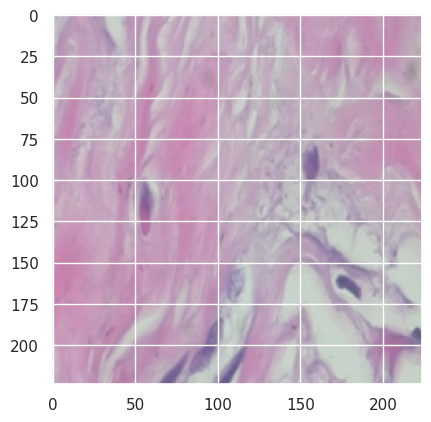

In [ ]:
from keras.preprocessing import image
label = {0:"benign", 1:"malignant"}
img_ = Image.open("/content/drive/MyDrive/Breast_Cancer_Project/BreaKHis 400X/train/benign/SOB_B_A-14-22549AB-400-002.png").resize((224, 224))
imag = np.array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

In [ ]:
NASNetLarge, InceptionResNetV2, NASNetMobile

(<function keras.applications.nasnet.NASNetLarge(input_shape=None, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000, classifier_activation='softmax')>,
 <function keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax', **kwargs)>,
 <function keras.applications.nasnet.NASNetMobile(input_shape=None, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000, classifier_activation='softmax')>)

In [ ]:
nasnet = NASNetLarge(input_shape=(224,224,3),
            include_top=False,
            weights='imagenet')

model = build_model(nasnet, lr = 1e-4)
model.summary()

343610240/343610240 [==============================] - 15s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 4032)        84916818  
                                                                 
 conv2d_13 (Conv2D)          (None, 5, 5, 16)          580624    
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 5, 5, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 3, 3, 32)          4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 3, 3, 32)         0         
 g2D)                                                            
                                                    

In [ ]:
history5 = model.fit(
    train_gen.flow(X_train, Y_train, batch_size=32),
    steps_per_epoch=X_train.shape[0] / 32,
    epochs=10,
    validation_data=(X_test, Y_test),
)

Epoch 1/10
35/35 [==============================] - 28s 783ms/step - loss: 0.3698 - accuracy: 0.8676 - val_loss: 0.7681 - val_accuracy: 0.3413
Epoch 2/10
35/35 [==============================] - 28s 781ms/step - loss: 0.3512 - accuracy: 0.8885 - val_loss: 0.7701 - val_accuracy: 0.3266
Epoch 3/10
35/35 [==============================] - 19s 526ms/step - loss: 0.3491 - accuracy: 0.8711 - val_loss: 0.7424 - val_accuracy: 0.3835
Epoch 4/10
35/35 [==============================] - 18s 497ms/step - loss: 0.3421 - accuracy: 0.8946 - val_loss: 0.7817 - val_accuracy: 0.3468
Epoch 5/10
35/35 [==============================] - 18s 506ms/step - loss: 0.3062 - accuracy: 0.9042 - val_loss: 0.7321 - val_accuracy: 0.4000
Epoch 6/10
35/35 [==============================] - 20s 551ms/step - loss: 0.2994 - accuracy: 0.9042 - val_loss: 0.7048 - val_accuracy: 0.4642
Epoch 7/10
35/35 [==============================] - 18s 511ms/step - loss: 0.3008 - accuracy: 0.9068 - val_loss: 0.6833 - val_accuracy: 0.5303

In [ ]:
model.evaluate(X_test, Y_test)

18/18 [==============================] - 6s 351ms/step - loss: 0.7550 - accuracy: 0.6771


[0.7549578547477722, 0.6770642399787903]

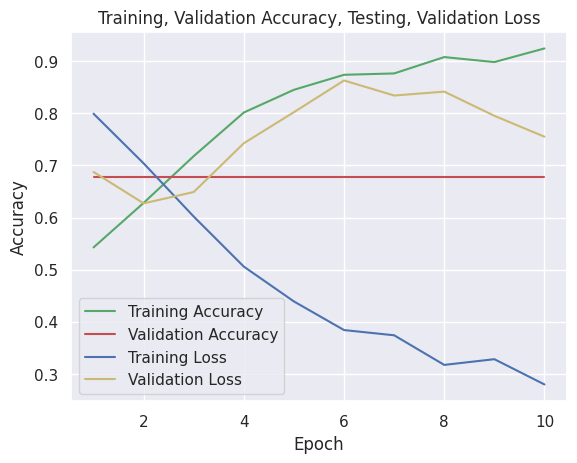

<Figure size 640x480 with 0 Axes>

In [ ]:
accuracy_plot(history5)

1/1 [==============================] - 5s 5s/step
[1]
malignant


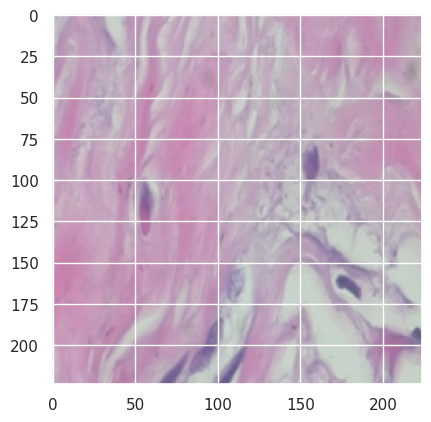

In [ ]:
from keras.preprocessing import image
label = {0:"benign", 1:"malignant"}
img_ = Image.open("/content/drive/MyDrive/Breast_Cancer_Project/BreaKHis 400X/train/benign/SOB_B_A-14-22549AB-400-002.png").resize((224, 224))
imag = np.array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

In [ ]:
nasnetmob = NASNetMobile(input_shape=(224,224,3),
            include_top=False,
            weights='imagenet')

model = build_model(nasnetmob, lr = 1e-4)
model.summary()

19993432/19993432 [==============================] - 2s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 conv2d_16 (Conv2D)          (None, 5, 5, 16)          152080    
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 5, 5, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 3, 3, 32)          4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 3, 3, 32)         0         
 g2D)                                                            
                                                       

In [ ]:
history6 = model.fit(
    train_gen.flow(X_train, Y_train, batch_size=32),
    steps_per_epoch=X_train.shape[0] / 32,
    epochs=10,
    validation_data=(X_test, Y_test),
)

In [ ]:
model.evaluate(X_test, Y_test)

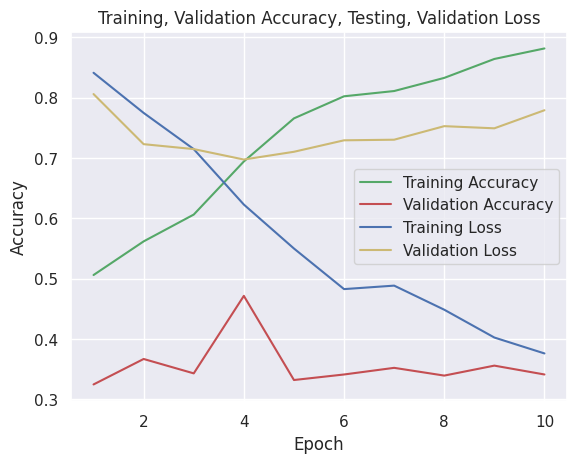

<Figure size 640x480 with 0 Axes>

In [ ]:
accuracy_plot(history6)

In [ ]:
from keras.preprocessing import image
label = {0:"benign", 1:"malignant"}
img_ = Image.open("/content/drive/MyDrive/Breast_Cancer_Project/BreaKHis 400X/train/benign/SOB_B_A-14-22549AB-400-002.png").resize((224, 224))
imag = np.array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

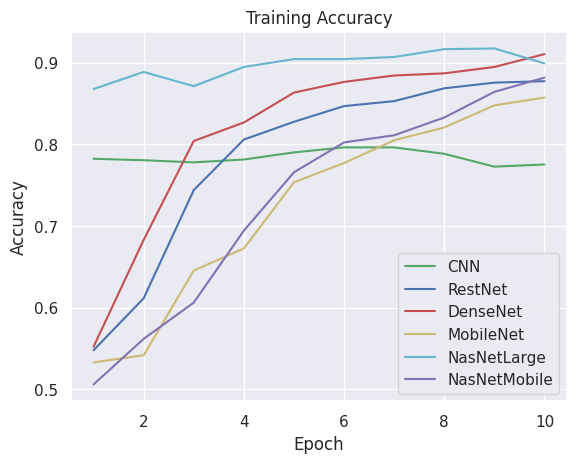

<Figure size 640x480 with 0 Axes>

In [ ]:
model_names = ['CNN', 'RestNet', 'DenseNet', 'MobileNet', 'NasNetLarge', 'NasNetMobile']

sns.set()
Cnnacc = history1.history['accuracy']
Resacc = history2.history['accuracy']
Denseacc = history3.history['accuracy']
Mobacc = history4.history['accuracy']
Nasacc = history5.history['accuracy']
NasMobacc = history6.history['accuracy']
step_per_epoch = range(1, len(Cnnacc) + 1)
plt.plot(step_per_epoch, Cnnacc, color='g')
plt.plot(step_per_epoch, Resacc, color='b')
plt.plot(step_per_epoch, Denseacc, color='r')
plt.plot(step_per_epoch, Mobacc, color='y')
plt.plot(step_per_epoch, Nasacc, color='c')
plt.plot(step_per_epoch, NasMobacc, color='m')
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(model_names)

plt.figure()
plt.show()

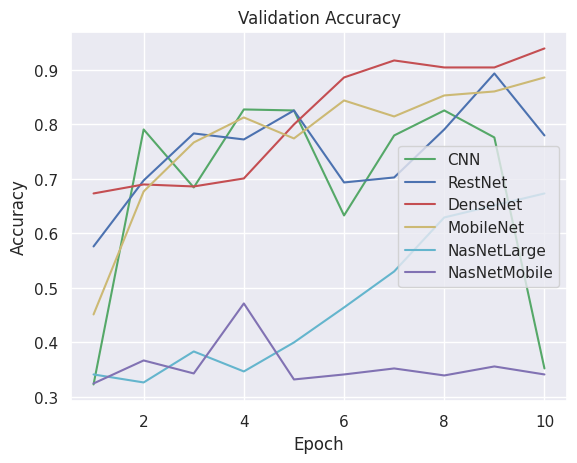

<Figure size 640x480 with 0 Axes>

In [ ]:
model_names = ['CNN', 'RestNet', 'DenseNet', 'MobileNet', 'NasNetLarge', 'NasNetMobile']

sns.set()
Cnnacc = history1.history['val_accuracy']
Resacc = history2.history['val_accuracy']
Denseacc = history3.history['val_accuracy']
Mobacc = history4.history['val_accuracy']
Nasacc = history5.history['val_accuracy']
NasMobacc = history6.history['val_accuracy']
step_per_epoch = range(1, len(Cnnacc) + 1)
plt.plot(step_per_epoch, Cnnacc, color='g')
plt.plot(step_per_epoch, Resacc, color='b')
plt.plot(step_per_epoch, Denseacc, color='r')
plt.plot(step_per_epoch, Mobacc, color='y')
plt.plot(step_per_epoch, Nasacc, color='c')
plt.plot(step_per_epoch, NasMobacc, color='m')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(model_names)

plt.figure()
plt.show()